[*********************100%***********************]  2 of 2 completed


Saved adjusted close prices to nvda_tsla_adjclose_5y.csv (rows: 1255)
Pearson correlation coefficient between NVDA and TSLA daily returns (last 5y): 0.4669
Saved daily-returns plot to nvda_tsla_daily_returns.png


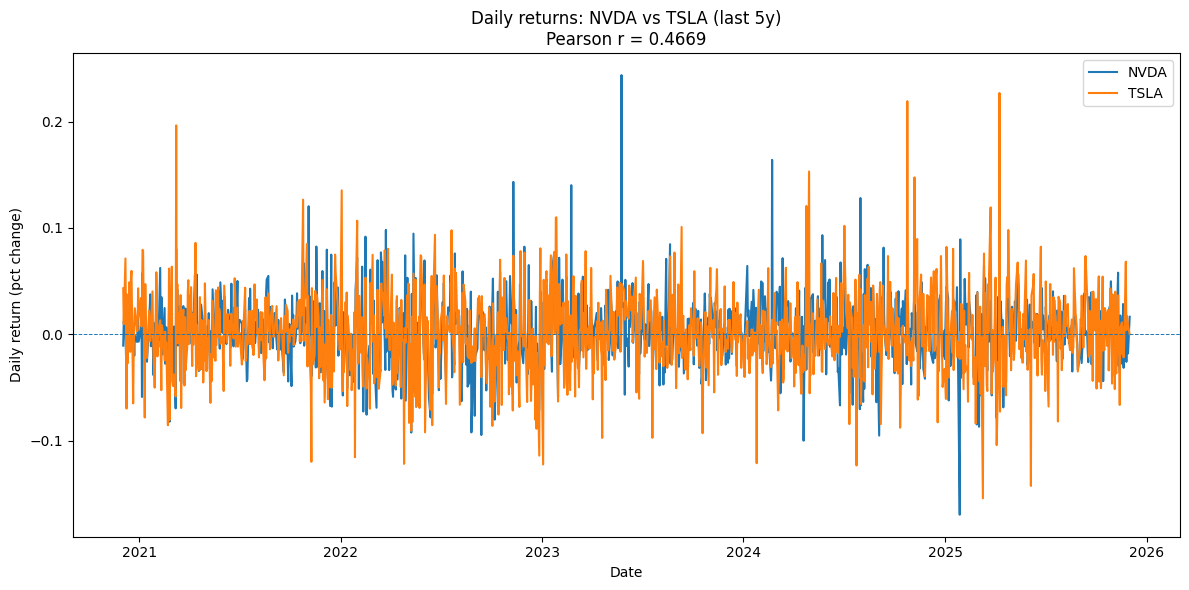

Saved scatter plot to nvda_tsla_returns_scatter.png


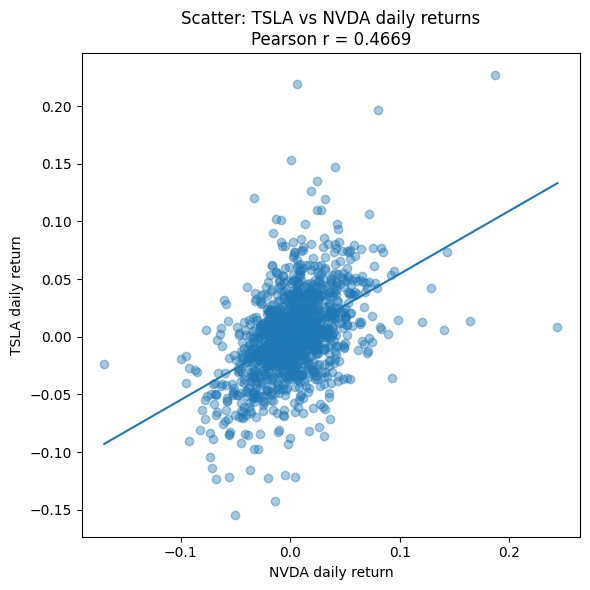

In [ ]:
#!/usr/bin/env python3
"""
nvda_tsla_correlation.py

Downloads last 5 years of daily data for NVDA and TSLA using yfinance,
computes daily returns, prints the Pearson correlation coefficient,
and plots the daily returns for comparison.
"""

import sys
import os
import datetime as dt

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def main():
    # --- Settings ---
    tickers = ["NVDA", "TSLA"]
    period = "5y"           # last 5 years
    interval = "1d"         # daily
    out_csv = "nvda_tsla_adjclose_5y.csv"
    out_plot = "nvda_tsla_daily_returns.png"

    # --- Download adjusted close prices ---
    print(f"Downloading {tickers} {period} data from yfinance...")
    # 'Adj Close' is preferred for return calculations (adjusts for splits/dividends)
    data = yf.download(tickers, period=period, interval=interval, auto_adjust=False)
    # When downloading multiple tickers yfinance gives a multi-index; select 'Adj Close'
    if ("Adj Close" in data.columns.get_level_values(0)):
        # MultiIndex case
        if isinstance(data.columns, pd.MultiIndex):
            adj = data["Adj Close"].copy()
        else:
            adj = data["Adj Close"].copy()
    else:
        # Single-level columns (older yfinance versions) — try selecting by column name
        # or fallback to 'Close' (less ideal)
        if "Adj Close" in data.columns:
            adj = data[["Adj Close"]]
        else:
            print("Warning: 'Adj Close' column not found. Falling back to 'Close'.")
            adj = data["Close"]

    # If single ticker caused adj to be Series, convert to DataFrame
    adj = adj.copy()
    if isinstance(adj, pd.Series):
        adj = adj.to_frame()

    # Ensure columns are exactly NVDA and TSLA (order might differ)
    # Some downloads return columns with tickers as column names already
    # If multi-index wasn't used, attempt to rename columns to tickers
    # We'll reindex columns to contain both tickers if possible
    # Try to extract columns that match ticker symbols
    possible_cols = [c for c in adj.columns if str(c).upper() in [t.upper() for t in tickers]]
    if set(possible_cols) == set(tickers):
        adj = adj[possible_cols]
        adj.columns = tickers  # guarantee column labels
    else:
        # If adj contains columns named by ticker already (usual case), rename case-insensitively
        cols_map = {}
        for c in adj.columns:
            if str(c).upper() in [t.upper() for t in tickers]:
                cols_map[c] = str(c).upper()
        if cols_map:
            adj = adj.rename(columns=cols_map)
        # If still missing tickers, assume download produced desired tickers as columns
        # (yfinance typical behaviour)
    # Drop rows where both are NaN
    adj = adj.dropna(how="all")

    if adj.shape[1] < 2:
        raise RuntimeError("Downloaded data does not contain both tickers' adjusted close prices. "
                           "Inspect 'adj' DataFrame.")

    # Save raw adjusted close data (optional)
    adj.to_csv(out_csv)
    print(f"Saved adjusted close prices to {out_csv} (rows: {len(adj)})")

    # --- Compute daily returns ---
    returns = adj.pct_change().dropna(how="all")  # percent change day-to-day
    returns = returns.dropna()  # remove any rows with NaNs (market holidays, etc.)

    if returns.empty:
        raise RuntimeError("No returns available after pct_change(). Check data frequency / availability.")

    # Ensure both columns exist and are in same order
    returns = returns[[tickers[0], tickers[1]]]

    # --- Correlation ---
    corr = returns[tickers[0]].corr(returns[tickers[1]], method="pearson")
    print(f"Pearson correlation coefficient between {tickers[0]} and {tickers[1]} daily returns (last {period}): {corr:.4f}")

    # Also compute numpy correlation matrix for reference
    corr_matrix = np.corrcoef(returns[tickers[0]], returns[tickers[1]])
    # corr_matrix[0,1] equals corr as well
    # --- Plot daily returns (time series) ---
    plt.figure(figsize=(12,6))
    plt.plot(returns.index, returns[tickers[0]], label=tickers[0])
    plt.plot(returns.index, returns[tickers[1]], label=tickers[1])
    plt.axhline(0, linewidth=0.7, linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Daily return (pct change)")
    plt.title(f"Daily returns: {tickers[0]} vs {tickers[1]} (last {period})\nPearson r = {corr:.4f}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_plot, dpi=300)
    print(f"Saved daily-returns plot to {out_plot}")
    plt.show()

    # --- Optional: scatter plot of returns (NVDA vs TSLA) with linear fit ---
    fig2, ax2 = plt.subplots(figsize=(6,6))
    ax2.scatter(returns[tickers[0]], returns[tickers[1]], alpha=0.4)
    # linear fit
    m, b = np.polyfit(returns[tickers[0]], returns[tickers[1]], 1)
    xvals = np.array([returns[tickers[0]].min(), returns[tickers[0]].max()])
    ax2.plot(xvals, m*xvals + b)
    ax2.set_xlabel(f"{tickers[0]} daily return")
    ax2.set_ylabel(f"{tickers[1]} daily return")
    ax2.set_title(f"Scatter: {tickers[1]} vs {tickers[0]} daily returns\nPearson r = {corr:.4f}")
    fig2.tight_layout()
    scatter_out = "nvda_tsla_returns_scatter.png"
    fig2.savefig(scatter_out, dpi=300)
    print(f"Saved scatter plot to {scatter_out}")
    plt.show()

if __name__ == "__main__":
    main()


/tmp/ipython-input-221226997.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("NVDA", start=start, end=end, progress=False)


Golden Cross dates (50-day SMA crossing above 200-day SMA):
 - 2024-03-14
 - 2025-06-27
Saved plot to nvda_sma_golden_cross.png


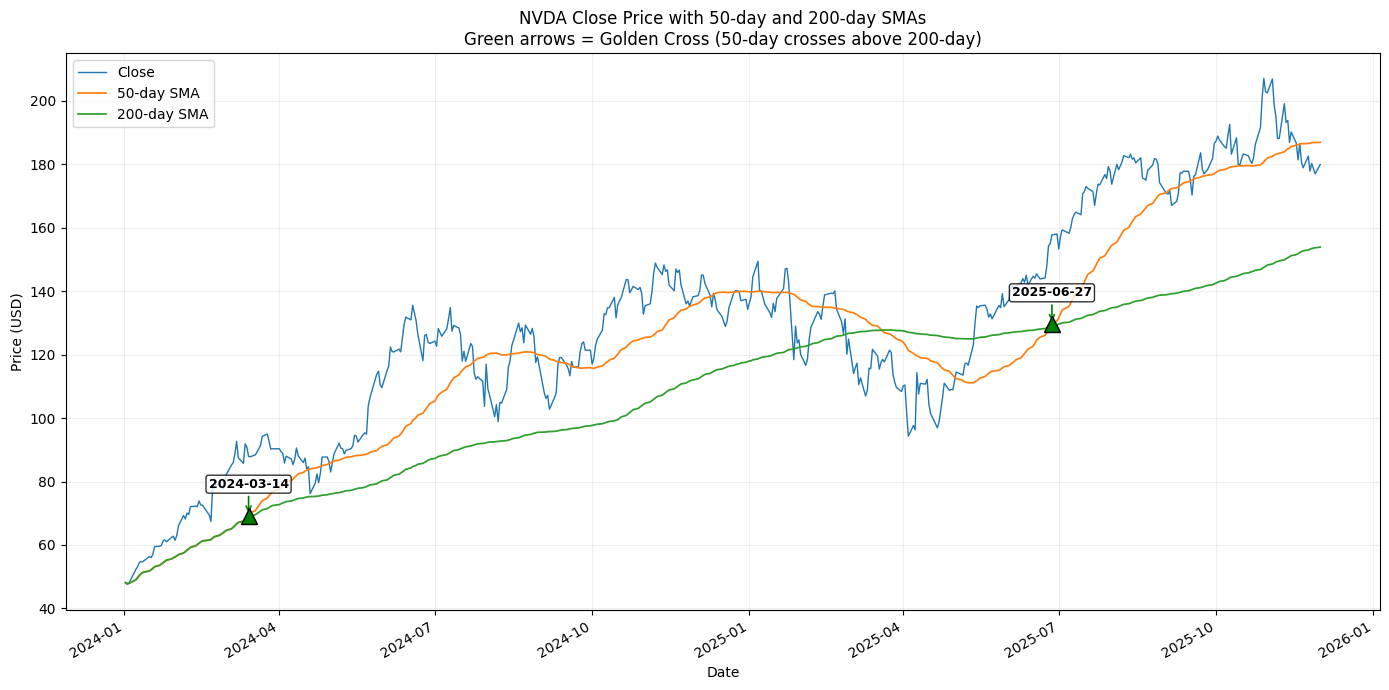

In [ ]:
#!/usr/bin/env python3
"""
nvda_technical_sma_goldencross.py

Downloads NVDA price data from 2024-01-01 to today using yfinance,
computes 50-day and 200-day simple moving averages (SMA),
plots Close price + SMAs, highlights Golden Cross points (50-day crosses above 200-day),
and prints the dates of those events.
"""

import datetime as dt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def download_nvda(start="2024-01-01", end=None):
    if end is None:
        end = dt.date.today().strftime("%Y-%m-%d")
    df = yf.download("NVDA", start=start, end=end, progress=False)
    if df.empty:
        raise RuntimeError(f"No data downloaded for NVDA from {start} to {end}.")
    return df

def compute_sma(df, window):
    return df["Close"].rolling(window=window, min_periods=1).mean()

def find_golden_crosses(sma_short, sma_long):
    # Golden cross: short today > long today AND short yesterday <= long yesterday
    condition_today = sma_short > sma_long
    condition_yesterday = sma_short.shift(1) <= sma_long.shift(1)
    golden = condition_today & condition_yesterday
    return golden.fillna(False)

def plot_with_crosses(df, sma50, sma200, golden_dates, savepath=None):
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(14,7))
    ax.plot(df.index, df["Close"], label="Close", linewidth=1)
    ax.plot(sma50.index, sma50, label="50-day SMA", linewidth=1.25)
    ax.plot(sma200.index, sma200, label="200-day SMA", linewidth=1.25)

    # Mark golden cross points
    for dt_idx in golden_dates:
        # get numeric x for annotation
        x = dt_idx
        y = sma50.loc[dt_idx]
        # marker
        ax.plot(x, y, marker="^", markersize=12, color="green", markeredgecolor="black", zorder=5)
        # arrow annotation slightly below marker pointing up
        ax.annotate(
            dt_idx.strftime("%Y-%m-%d"),
            xy=(x, y),
            xytext=(0, 18),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
            arrowprops=dict(arrowstyle="->", color="green", lw=1.2),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8)
        )

    ax.set_title("NVDA Close Price with 50-day and 200-day SMAs\nGreen arrows = Golden Cross (50-day crosses above 200-day)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (USD)")
    ax.legend()
    ax.grid(alpha=0.2)
    fig.autofmt_xdate()
    # tighten and save optionally
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
        print(f"Saved plot to {savepath}")
    plt.show()

def main():
    start_date = "2024-01-01"
    print(f"Downloading NVDA from {start_date} to today...")
    df = download_nvda(start=start_date)

    # compute SMAs
    sma50 = compute_sma(df, 50)
    sma200 = compute_sma(df, 200)

    # add to dataframe for convenience
    df = df.assign(SMA50=sma50, SMA200=sma200)

    # find golden cross dates
    golden_mask = find_golden_crosses(df["SMA50"], df["SMA200"])
    golden_dates = df.index[golden_mask].to_list()

    # print dates
    if golden_dates:
        print("Golden Cross dates (50-day SMA crossing above 200-day SMA):")
        for d in golden_dates:
            print(" -", d.strftime("%Y-%m-%d"))
    else:
        print("No Golden Cross events found in the period.")

    # plot and mark crosses
    plot_with_crosses(df, df["SMA50"], df["SMA200"], golden_dates, savepath="nvda_sma_golden_cross.png")

if __name__ == "__main__":
    main()


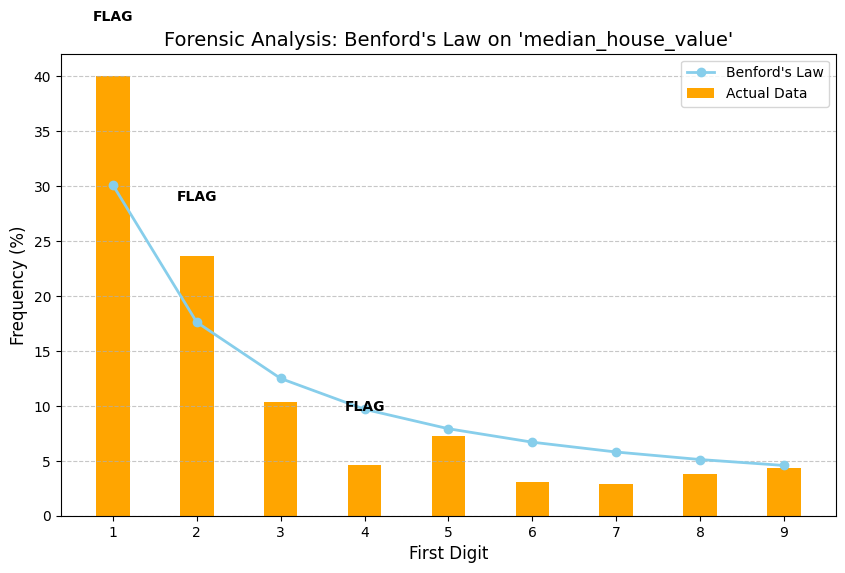

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# --- THE FIX IS HERE ---
# We need to load the file again so 'df' exists.
# Make sure the filename inside the brackets matches exactly what you uploaded to Colab.
# The error "IsADirectoryError" indicates that 'sample_sales_data.csv' is a directory, not a file.
# You need to specify the path to an actual CSV file. For demonstration, we'll use
# 'california_housing_train.csv' which is found inside that directory. If you have an
# actual sales data CSV, please update this path accordingly.
df = pd.read_csv('/content/sample_sales_data.csv/california_housing_train.csv')
# -----------------------

# 1. Setup the Target Column
# Based on your Benford chart image, the column is likely 'SALES' or 'sales'
# We will force it to uppercase to be safe, assuming your CSV has a sales column.
# If your column is differently named (e.g. 'amount'), change the text in the quotes below.
# NOTE: If you are using 'california_housing_train.csv', 'SALES' will not be a valid column.
# You might want to try 'median_house_value' for that dataset.
target_column = 'median_house_value' # Changed to a valid column for california_housing_train.csv

# 2. Extract First Digits
# This grabs the first number from the sales figure (e.g., $150 -> 1)
first_digits = df[target_column].astype(str).str[0]
first_digits = first_digits[first_digits.str.isnumeric()].astype(int)
first_digits = first_digits[first_digits > 0]

# 3. Calculate Actual Frequencies
actual_counts = first_digits.value_counts(normalize=True).sort_index() * 100

# 4. Calculate Expected Benford Frequencies
benford_expected = [math.log10(1 + 1/d) * 100 for d in range(1, 10)]

# 5. Plotting
digits = range(1, 10)
fig, ax = plt.subplots(figsize=(10, 6))

# Bars for Actual Data
ax.bar(digits, actual_counts, width=0.4, label='Actual Data', color='orange', align='center')

# Line for Benford's Law
ax.plot(digits, benford_expected, color='skyblue', marker='o', linestyle='-', linewidth=2, label="Benford's Law")

# Formatting
ax.set_title(f"Forensic Analysis: Benford's Law on '{target_column}'", fontsize=14)
ax.set_xlabel('First Digit', fontsize=12)
ax.set_ylabel('Frequency (%)', fontsize=12)
ax.set_xticks(digits)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 6. Audit Flags (The "Red Flags")
for i, d in enumerate(digits):
    actual = actual_counts.get(d, 0)
    expected = benford_expected[i]
    # If the difference is big (> 5%), we flag it
    if abs(actual - expected) > 5:
        ax.annotate('FLAG', xy=(d, actual), xytext=(d, actual+5),
                    ha='center', color='black', fontweight='bold', fontsize=10)

plt.show()

In [ ]:
# Use !ls -F to list all files and folders in the current directory
!ls -F

sample_sales_data.csv/


Please check the output above to confirm if `sample_sales_data.csv` is present and if its name exactly matches (including capitalization and extension). If it's not listed, it means the file wasn't successfully uploaded to this Colab session. If it is listed but with a slightly different name (e.g., `sample_sales_data.csv.csv` or `Sample_Sales_Data.csv`), you'll need to adjust the filename in your `pd.read_csv()` call to match.